In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as D
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import pandas as pd
from cutbayesflow import CutBayesFlow, train_cut_bayes_flow
from cutbayesflow.utils import get_marginal_samples

# ─────────────────────────────────────────────
# 0) Reproducibility & Common Settings
# ─────────────────────────────────────────────
seed = 1010
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = "cpu"

# Prior on eta: Gamma(2, 1)
alpha, beta = 2.0, 1.0
eta_dist = D.Gamma(concentration=alpha, rate=beta)
N_MC = 1000
eta_samples = eta_dist.sample((N_MC, 1))  # Fixed eta samples

# Grid for plotting
theta_grid = torch.linspace(-8, 8, 500).unsqueeze(1)

# ─────────────────────────────────────────────
# 1) Mixture-of-Gaussians: Conditional posterior p(θ | η)
# ─────────────────────────────────────────────
import torch
import torch.distributions as D

# Shared std dev for all dimensions
sigma1 = sigma2 = 1.5

# Mixing proportion π(η)
def pi1_fn(eta):
    return (0.2 + 0.5 * torch.sigmoid(4 * (eta - 2.0))).clamp(1e-6, 1 - 1e-6)

# List of mean functions for each θᵢ
mu1_fns = [
    lambda eta: 4.0 * torch.tanh(eta - 1.0),        # θ₁
    lambda eta: 6.0 * torch.tanh(eta - 2.0),         # θ₂
    lambda eta: 3.0 * torch.cos(2 * eta),           # θ₃
    # Add more if needed...
]

mu2_fns = [
    lambda eta: -4.0 * torch.tanh(eta + 1.0),       # θ₁
    lambda eta: -5.0 * torch.cos(eta),              # θ₂
    lambda eta: -6.0 * torch.sin(2 * eta),          # θ₃
    # Add more if needed...
]

# Generalized posterior log p(θ | η)
def posterior_log_p_theta_given_eta(theta, eta, data=None):
    eta = eta.view(-1, 1)  # Ensure shape [N, 1]
    N, p = theta.shape
    log_mix_sum = 0.0

    for i in range(p):
        theta_i = theta[:, i:i+1]
        mu1_i = mu1_fns[i](eta)
        mu2_i = mu2_fns[i](eta)

        p1 = torch.exp(D.Normal(mu1_i, sigma1).log_prob(theta_i))
        p2 = torch.exp(D.Normal(mu2_i, sigma2).log_prob(theta_i))

        log_mix_i = torch.log(pi1_fn(eta) * p1 + (1 - pi1_fn(eta)) * p2 + 1e-8)
        log_mix_sum += log_mix_i

    return log_mix_sum


# Placeholder prior (log-uniform)
def dummy_prior(theta):
    return torch.zeros(theta.size(0))



In [2]:
theta_dim=2
print("Training NeVI")
model_nevi_NSF=CutBayesFlow(
    prior_log_prob_fn=dummy_prior,
    likelihood_log_prob_fn=posterior_log_p_theta_given_eta,
    eta_dim=1, theta_dim=theta_dim,
    num_layers=16, hidden_features=64,
    num_bins=25, tail_bound=25.0,
    use_residual_blocks=True, num_blocks=2,flow_type="NSF"
)

loss_history_NSF = train_cut_bayes_flow(
    model_nevi_NSF,
    eta_samples,
    None,
    epochs=2000,
    lr=5e-3,
    log_interval=50,
    seed=seed,
    verbose=True
)

print("NeVI NSF is finished")

Training NeVI
Using batch_size=1000 (full-batch: True)
Step     0 | Loss: 5.108922 | LR: 5.00e-03 | θ 1% quantile: [-2.24e+00, -1.17e+00]
Step    50 | Loss: 1.073488 | LR: 5.00e-03 | θ 1% quantile: [-8.78e+00, -7.42e+00]
Step   100 | Loss: 0.378444 | LR: 5.00e-03 | θ 1% quantile: [-7.98e+00, -8.89e+00]
Step   150 | Loss: 0.165353 | LR: 5.00e-03 | θ 1% quantile: [-7.51e+00, -8.44e+00]
Step   200 | Loss: 0.108337 | LR: 5.00e-03 | θ 1% quantile: [-7.89e+00, -9.54e+00]
Step   250 | Loss: 0.120034 | LR: 5.00e-03 | θ 1% quantile: [-7.80e+00, -8.78e+00]
Step   300 | Loss: 0.185500 | LR: 5.00e-03 | θ 1% quantile: [-8.04e+00, -1.02e+01]
Step   350 | Loss: 0.089265 | LR: 5.00e-03 | θ 1% quantile: [-7.61e+00, -8.51e+00]
Step   400 | Loss: 0.085798 | LR: 5.00e-03 | θ 1% quantile: [-8.07e+00, -7.78e+00]
Step   450 | Loss: 0.138034 | LR: 5.00e-03 | θ 1% quantile: [-8.10e+00, -8.35e+00]
Epoch 00464: reducing learning rate of group 0 to 2.5000e-03.
Step   500 | Loss: 0.077012 | LR: 2.50e-03 | θ 1% qua

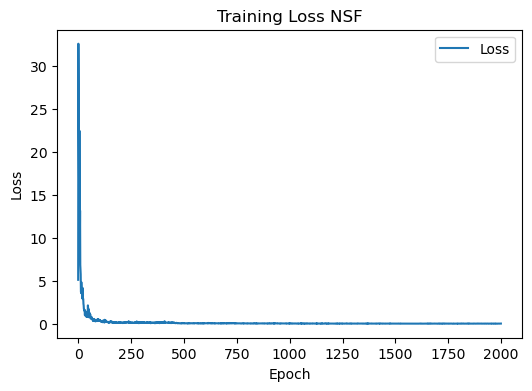

In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot Loss Curve
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(6, 4))
plt.plot(loss_history_NSF, label="Loss")
plt.title("Training Loss NSF")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [4]:
print("Training NeVI")
model_nevi_MAF=CutBayesFlow(
    prior_log_prob_fn=dummy_prior,
    likelihood_log_prob_fn=posterior_log_p_theta_given_eta,
    eta_dim=1, theta_dim=theta_dim,
    num_layers=10, hidden_features=16,
    num_bins=25, tail_bound=15.0,
    use_residual_blocks=True, num_blocks=2
)

loss_history_MAF = train_cut_bayes_flow(
    model_nevi_MAF,
    eta_samples,
    None,
    epochs=2000,
    lr=5e-3,
    log_interval=200,
    seed=seed,
    verbose=True
)

print("NeVI MAF is finished")

Training NeVI
Using batch_size=1000 (full-batch: True)
Step     0 | Loss: 52.454861 | LR: 5.00e-03 | θ 1% quantile: [-6.15e+00, -8.19e+00]
Step   200 | Loss: 0.696525 | LR: 5.00e-03 | θ 1% quantile: [-7.20e+00, -9.81e+00]
Step   400 | Loss: 0.207606 | LR: 5.00e-03 | θ 1% quantile: [-8.77e+00, -8.56e+00]
Step   600 | Loss: 0.092612 | LR: 5.00e-03 | θ 1% quantile: [-8.27e+00, -8.21e+00]
Step   800 | Loss: 0.104217 | LR: 5.00e-03 | θ 1% quantile: [-9.84e+00, -8.41e+00]
Epoch 00821: reducing learning rate of group 0 to 2.5000e-03.
Step  1000 | Loss: 0.040209 | LR: 2.50e-03 | θ 1% quantile: [-8.00e+00, -8.53e+00]
Epoch 01080: reducing learning rate of group 0 to 1.2500e-03.
Step  1200 | Loss: 0.039421 | LR: 1.25e-03 | θ 1% quantile: [-7.46e+00, -7.86e+00]
Epoch 01385: reducing learning rate of group 0 to 6.2500e-04.
Step  1400 | Loss: 0.045005 | LR: 6.25e-04 | θ 1% quantile: [-9.23e+00, -8.33e+00]
Epoch 01499: reducing learning rate of group 0 to 3.1250e-04.
Step  1600 | Loss: 0.026262 | LR

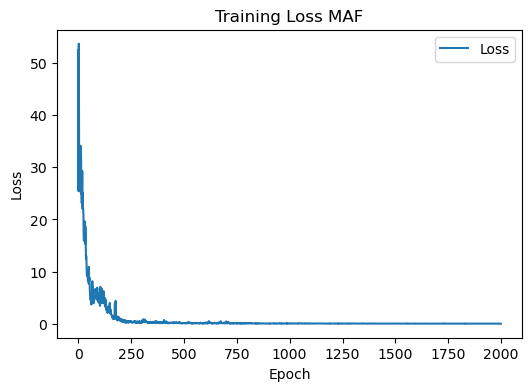

In [5]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot Loss Curve
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(6, 4))
plt.plot(loss_history_MAF, label="Loss")
plt.title("Training Loss MAF")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()



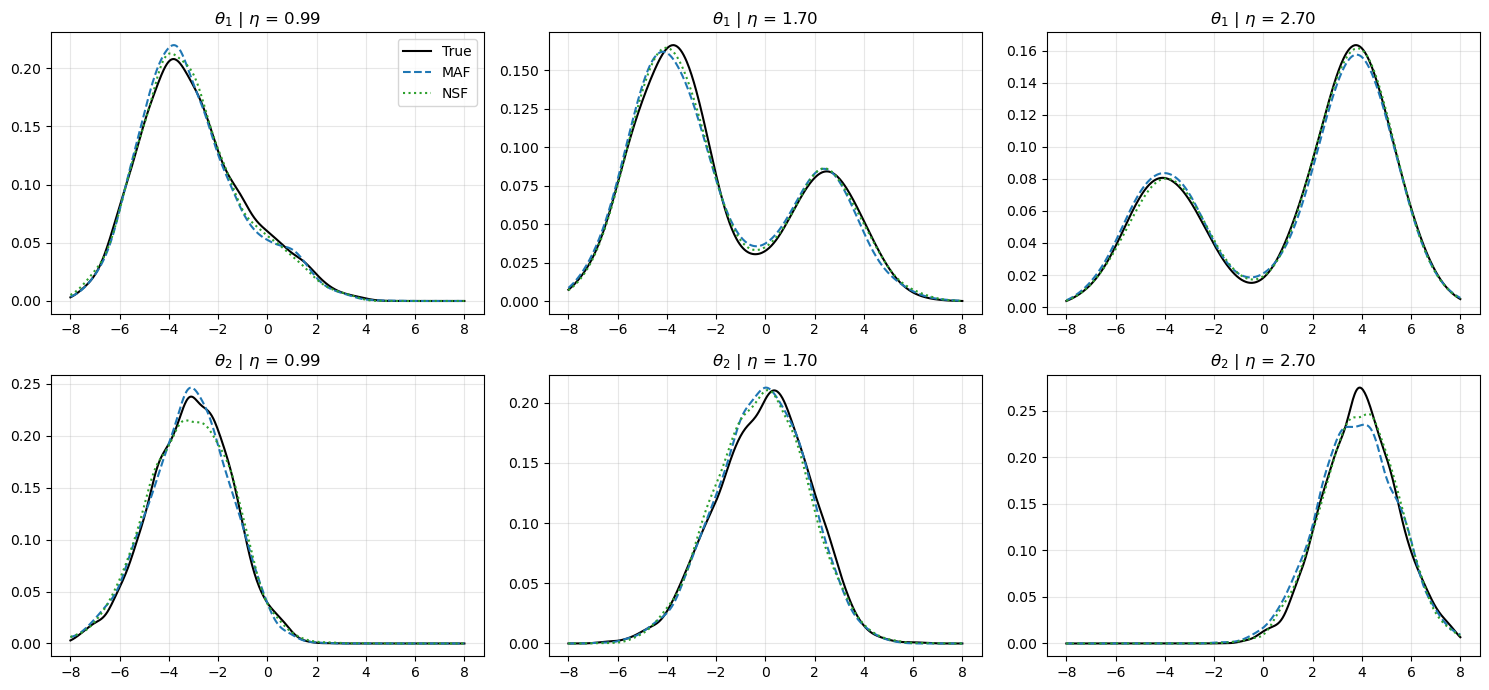

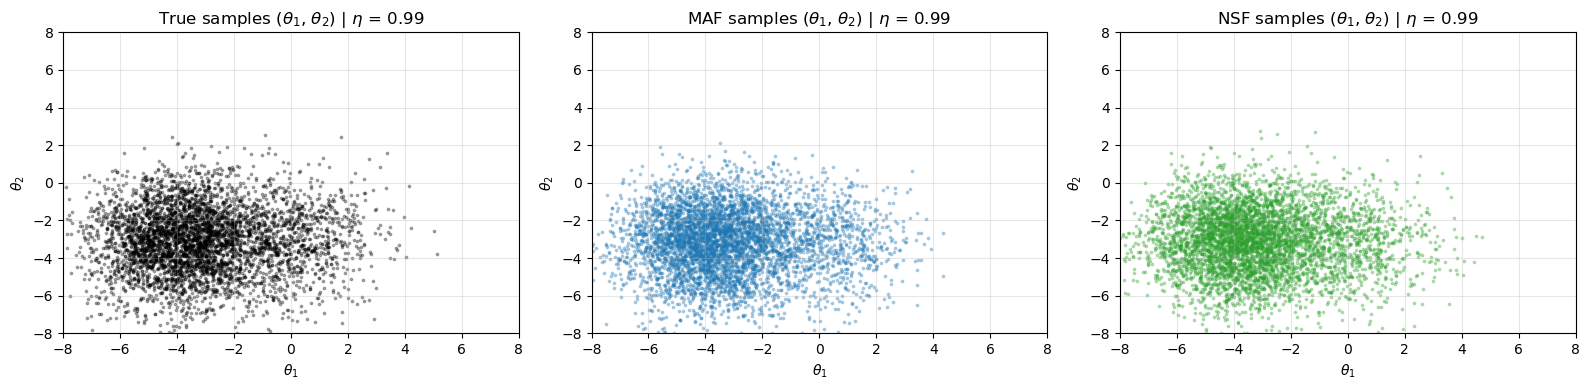

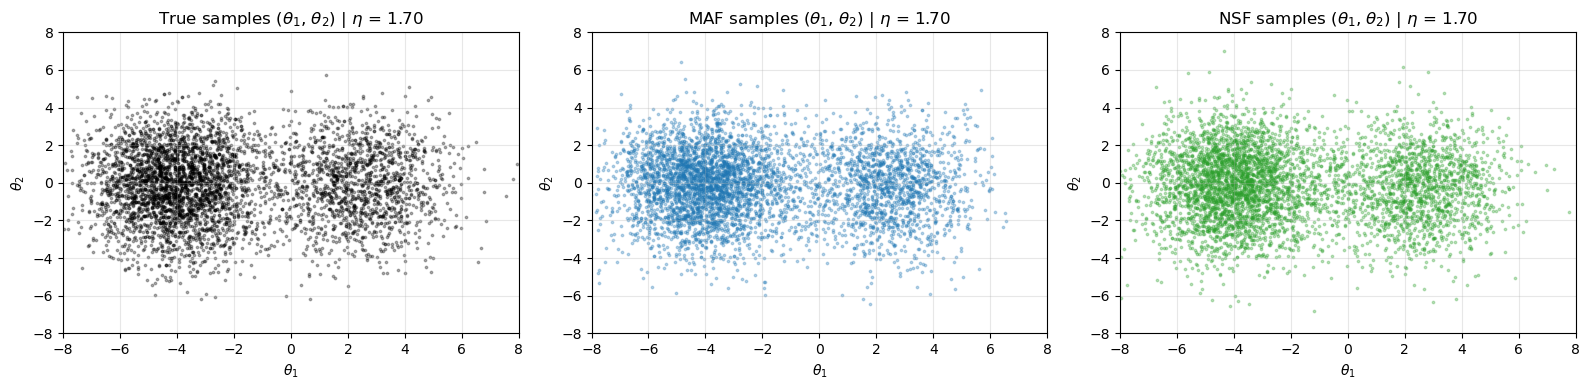

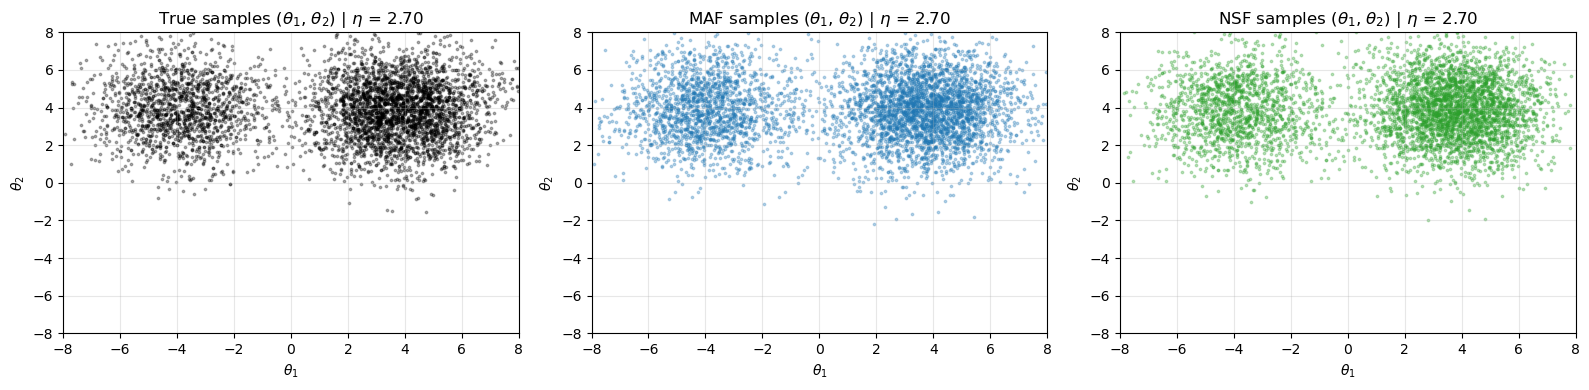

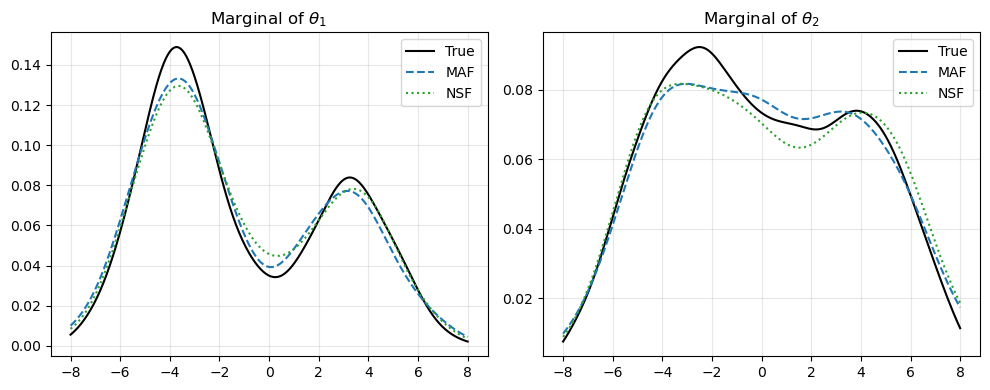

In [6]:
colors = {"True": "black", "MAF": "#1f77b4", "NSF": "#2ca02c"}
x = np.linspace(-8, 8, 500)
N_samples = 5000
theta_dim = model_nevi_MAF.sample_q_theta_given_eta(torch.ones(1, 1)).shape[1]

# ─────────────────────────────────────────────
# Conditional KDE Plots: θ_i | η
# ─────────────────────────────────────────────
eta_vals = [eta_samples.quantile(q, 0).item() for q in [0.25, 0.5, 0.75]]
fig, axs = plt.subplots(theta_dim, len(eta_vals), figsize=(5 * len(eta_vals), 3.5 * theta_dim))

for i, eta_val in enumerate(eta_vals):
    eta_tensor = torch.full((N_samples, 1), eta_val)

    with torch.no_grad():
        theta_maf = model_nevi_MAF.sample_q_theta_given_eta(eta_tensor).numpy()
        theta_nsf = model_nevi_NSF.sample_q_theta_given_eta(eta_tensor).numpy()

        grid = torch.from_numpy(np.random.uniform(-8, 8, (100000, theta_dim))).float()
        eta_cond = torch.full((100000, 1), eta_val)
        logp = posterior_log_p_theta_given_eta(grid, eta_cond)
        p = torch.exp(logp).numpy().ravel()
        p /= p.sum()
        theta_true = grid.numpy()[np.random.choice(len(grid), N_samples, p=p)]

    for d in range(theta_dim):
        ax = axs[d, i] if theta_dim > 1 else axs[i]
        kde_true = gaussian_kde(theta_true[:, d])
        kde_maf = gaussian_kde(theta_maf[:, d])
        kde_nsf = gaussian_kde(theta_nsf[:, d])

        ax.plot(x, kde_true(x), color=colors["True"], label="True")
        ax.plot(x, kde_maf(x), color=colors["MAF"], linestyle="--", label="MAF")
        ax.plot(x, kde_nsf(x), color=colors["NSF"], linestyle=":", label="NSF")
        ax.set_title(f"$\\theta_{{{d+1}}}$ | $\\eta$ = {eta_val:.2f}")
        ax.grid(alpha=0.3)
        if d == 0 and i == 0:
            ax.legend()

plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────
# Pairwise Scatter Plot: (θ₁, θ₂) | η
# ─────────────────────────────────────────────
if theta_dim >= 2:
    for i, eta_val in enumerate(eta_vals):
        eta_tensor = torch.full((N_samples, 1), eta_val)

        with torch.no_grad():
            theta_maf = model_nevi_MAF.sample_q_theta_given_eta(eta_tensor).numpy()
            theta_nsf = model_nevi_NSF.sample_q_theta_given_eta(eta_tensor).numpy()

            grid = torch.from_numpy(np.random.uniform(-8, 8, (100000, theta_dim))).float()
            eta_cond = torch.full((100000, 1), eta_val)
            logp = posterior_log_p_theta_given_eta(grid, eta_cond)
            p = torch.exp(logp).numpy().ravel()
            p /= p.sum()
            theta_true = grid.numpy()[np.random.choice(len(grid), N_samples, p=p)]

        fig, ax = plt.subplots(1, 3, figsize=(16, 4))
        ax[0].scatter(theta_true[:, 0], theta_true[:, 1], s=3, alpha=0.3, color=colors["True"])
        ax[1].scatter(theta_maf[:, 0], theta_maf[:, 1], s=3, alpha=0.3, color=colors["MAF"])
        ax[2].scatter(theta_nsf[:, 0], theta_nsf[:, 1], s=3, alpha=0.3, color=colors["NSF"])

        for j, label in enumerate(["True", "MAF", "NSF"]):
            ax[j].set_title(f"{label} samples ($\\theta_1$, $\\theta_2$) | $\\eta$ = {eta_val:.2f}")
            ax[j].set_xlim(-8, 8)
            ax[j].set_ylim(-8, 8)
            ax[j].set_xlabel(r"$\theta_1$")
            ax[j].set_ylabel(r"$\theta_2$")
            ax[j].grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

# ─────────────────────────────────────────────
# Marginal KDEs: θ_i (integrated over η)
# ─────────────────────────────────────────────
with torch.no_grad():
    samples_maf = model_nevi_MAF.sample_q_theta_given_eta(eta_samples).detach().numpy()
    samples_nsf = model_nevi_NSF.sample_q_theta_given_eta(eta_samples).detach().numpy()

    grid = torch.from_numpy(np.random.uniform(-8, 8, (100000, theta_dim))).float()
    eta_rep = eta_samples[:100000]
    if eta_rep.shape[0] < 100000:
        eta_rep = eta_samples[torch.randint(0, eta_samples.shape[0], (100000,))]
    logp = posterior_log_p_theta_given_eta(grid, eta_rep)
    p = torch.exp(logp).numpy().ravel()
    p /= p.sum()
    samples_true = grid.numpy()[np.random.choice(len(grid), 5000, p=p)]

fig, axes = plt.subplots(1, theta_dim, figsize=(5 * theta_dim, 4))
if theta_dim == 1:
    axes = [axes]

for i in range(theta_dim):
    kde_true = gaussian_kde(samples_true[:, i])
    kde_maf = gaussian_kde(samples_maf[:, i])
    kde_nsf = gaussian_kde(samples_nsf[:, i])

    axes[i].plot(x, kde_true(x), label="True", color=colors["True"])
    axes[i].plot(x, kde_maf(x), label="MAF", color=colors["MAF"], linestyle="--")
    axes[i].plot(x, kde_nsf(x), label="NSF", color=colors["NSF"], linestyle=":")
    axes[i].set_title(f"Marginal of $\\theta_{{{i+1}}}$")
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [7]:
np.savez("/Users/jiafangsong/Desktop/Cut_Bayes_VI/NeVI_paper_results/others/appendixB_theta_nevi_cut_all_samples.npz",
         theta1_cond_true=theta_true[:, 0],
         theta1_cond_maf=theta_maf[:, 0],
         theta1_cond_nsf=theta_nsf[:, 0],
         theta2_cond_true=theta_true[:, 1] if theta_dim > 1 else np.zeros(N_samples),
         theta2_cond_maf=theta_maf[:, 1] if theta_dim > 1 else np.zeros(N_samples),
         theta2_cond_nsf=theta_nsf[:, 1] if theta_dim > 1 else np.zeros(N_samples),
         joint_cond_true=theta_true,
         joint_cond_maf=theta_maf,
         joint_cond_nsf=theta_nsf,
         theta1_marg_true=samples_true[:, 0],
         theta1_marg_maf=samples_maf[:, 0],
         theta1_marg_nsf=samples_nsf[:, 0],
         theta2_marg_true=samples_true[:, 1] if theta_dim > 1 else np.zeros(N_samples),
         theta2_marg_maf=samples_maf[:, 1] if theta_dim > 1 else np.zeros(N_samples),
         theta2_marg_nsf=samples_nsf[:, 1] if theta_dim > 1 else np.zeros(N_samples),
         joint_marg_true=samples_true,
         joint_marg_maf=samples_maf,
         joint_marg_nsf=samples_nsf,
         eta_val=eta_val)